# Understanding  how starbucks offers are distributed among the customer population and predicting how the customer will treat the offer.

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

From the data, differnt customers make decisions on whether to buy or not to buy coffee. some of the bahvrios of the customers might not be infleuced by the promotional offers. However in this case, I am interested in finding out how the promotions/ offers are distriuted amogn the differnt customer demographics.  I will also attempt ot predict how the customers will respond to the offers they receive using models.
I will evaluate the differnt characteristics of the customers adn how the offers are distributed amongst them.

This project is part of my Udacity Data Scientist Nanodegree program.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed


In [75]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploratory Data Analysis

## Here is the schema and explolation of each variable in the files:


### 1. Portfolio

In [76]:
portfolio.shape

(10, 6)

In [77]:
profile.shape

(17000, 5)

In [78]:
transcript.shape

(306534, 4)

In [79]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [80]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [81]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [82]:
portfolio.shape

(10, 6)

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

The portfolio dataset only contains 10 records/ rows and 6 columns. There are no missing values. The channel feature contains categorical variables that will be important for our ML model. I will therefore perfom some clearning and data encoding on it ot ensure that it is usable in my model.

Two columns in the portfolio dataset contain categorical variables, channels and offer_types that we can handle using on-hot-encoding.

In [83]:
# one hot encoding for channels column
mlb = MultiLabelBinarizer()
channels_df = pd.DataFrame(mlb.fit_transform(portfolio.channels), columns=['email', 'mobile', 'social', 'web'])

# drop the original channel column and add the new channels_df culumns to portfolio
portfolio = portfolio.join(channels_df).drop(columns = 'channels')


In [84]:
portfolio.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [85]:
# one hot encoding on the offer_type column
offer_df = pd.get_dummies(portfolio.offer_type, drop_first = True)
portfolio = portfolio.join(offer_df)

In [86]:
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,1,0


### Since we only have 10 rows, it is convenient to rename the id column variables into something meaningful and remove hte long string id entries
I will replace them with b1, b2, b3, b4 for bogo offer types, d1, d2, d3, d4 for discount offer type and info_1, info_2 for the informational offer type

In [87]:
# replace the keys (ids) with the names listed above
offer_dict = {
    'ae264e3637204a6fb9bb56bc8210ddfd':'b1',
    '4d5c57ea9a6940dd891ad53e9dbe8da0':'b2',
    '3f207df678b143eea3cee63160fa8bed':'info_1',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9':'b3',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7':'d1',
    '2298d6c36e964ae4a3e7e9706d1fb8c2':'d2',
    'fafdcd668e3743c1bb461111dcafc2a4':'d3',
    '5a8bc65990b245e5a138643cd4eb9837':'info_2',
    'f19421c1d4aa40978ebb69ca19b0e20d':'b4',
    '2906b810c7d4411798c6938adc9daaa5':'d4'    
}
portfolio = portfolio.copy()
portfolio.id = portfolio.id.map(offer_dict)

In [88]:
# reorder the columns to have id as the first column

portfolio = portfolio.reindex(columns=['id', 'offer_type', 'reward', 'difficulty', 'duration', 'email', 'mobile', 'social', 'web', 'discount', 'informational'])
portfolio.head()

,id,offer_type,reward,difficulty,duration,email,mobile,social,web,discount,informational
0,b1,bogo,10,10,7,1,1,1,0,0,0
1,b2,bogo,10,10,5,1,1,1,1,0,0
2,info_1,informational,0,0,4,1,1,0,1,0,1
3,b3,bogo,5,5,7,1,1,0,1,0,0
4,d1,discount,5,20,10,1,0,0,1,1,0


In [89]:
# rename id to offer_id
portfolio = portfolio.rename(columns={'id': 'offer_id'})

In [90]:
# let's save the cleaned dataset as a csv file
portfolio.to_csv('data/portfolio.csv', index=False)

### 2. Profile

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [91]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [92]:
profile.shape

(17000, 5)

In [93]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [94]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


The profile dataset has missing values in gender and income rows. There are a total of 17000 rows and 5 columns in the dataset. the age column has an outlier in the max age whcih is st at 118.  I will drop these entries with the age outlier and recheck the data for missing values

In [95]:
profile = profile[profile.age != 118]
profile.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [96]:
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

it looks like all rows that had age as 118 were also the same rows with missing income and gender values. our datset seems to have no missing values now. Dropping the values is the best method to hadnle these missing values. imputation would not make sense due to the gender column. There is not simple way to handle the gender missing values. However this means that we lose some data that wodul have been used in the machine learning model. 

In [97]:
# one-hot encoding for gender column
gender_clm  = pd.get_dummies(profile.gender, prefix='gend', drop_first=True)
profile = profile.join(gender_clm)
profile.head()

,gender,age,id,became_member_on,income,gend_M,gend_O
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,1,0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,1,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1,0


In [98]:
'''
    count the membership period for all the members in our profile dataset. to do this, 
    i will subtract the registration
    date of the mmber iwht that of the most recent member in the dataset. 
'''
most_recent_memb = pd.to_datetime(str(profile.became_member_on.max()), format = '%Y%m%d')
joined_date = pd.to_datetime(profile.became_member_on.astype(str), format = '%Y%m%d')
profile['membership_days'] = (most_recent_memb - joined_date).dt.days
profile.drop(columns='became_member_on', inplace = True)

In [99]:
profile.head()

,gender,age,id,income,gend_M,gend_O,membership_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,376
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,443
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,1,0,91
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,1,0,167
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1,0,257


our profile dataset is clean and we can save it now. we can also visualize some attributes about this dataset as shown below

In [100]:
# rename id column to person
profile = profile.rename(columns={'id': 'person'})

In [101]:
# saving profile dataset
profile.to_csv('data/profile.csv', index=False)

### Visualisations on profile data distribution
#### Age Visualisation

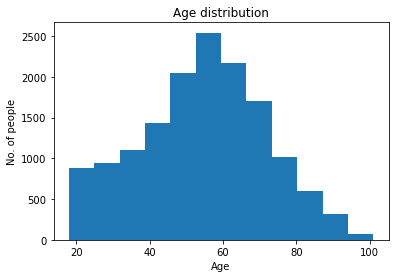

In [102]:
plt.hist(profile['age'], bins= 12)
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('No. of people');

#### Creating age group column

In [103]:
profile['age_group'] = pd.cut(profile['age'], bins=[17, 25, 35, 59, 105], labels=['teenager', 'young_adult',
                                                                                 'adult', 'senior_citizens'])

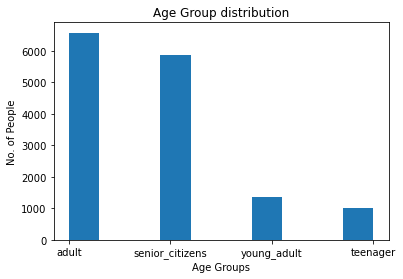

In [104]:
plt.hist(profile['age_group'])
plt.title('Age Group distribution')
plt.xlabel('Age Groups')
plt.ylabel('No. of People');

There is a high number of people aged between 40 and 80 years in the dataset whcih also translates to majority of the customers belong to Adult and Senior citizen age groups. 

#### Gender visualisation

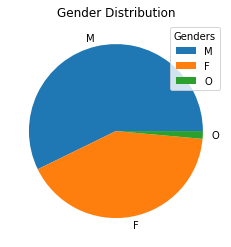

In [105]:

profile_gender_values = profile.gender.value_counts()
lbls = ['M', 'F', 'O']
data = profile_gender_values
plt.pie(data, labels=lbls);
plt.title("Gender Distribution")
plt.legend(title = "Genders")
plt.show()

#### Income histogram

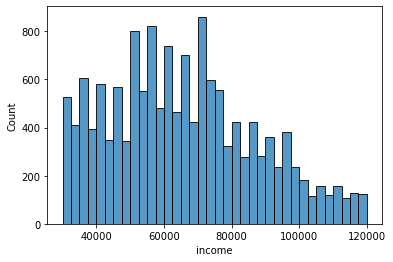

In [106]:
sns.histplot(profile['income']);

#### membership duration

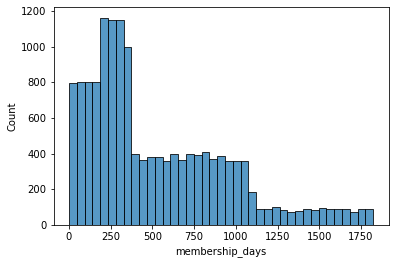

In [107]:
sns.histplot(profile['membership_days']);


### 3. Transcript
**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [108]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [109]:
transcript.shape

(306534, 4)

In [110]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


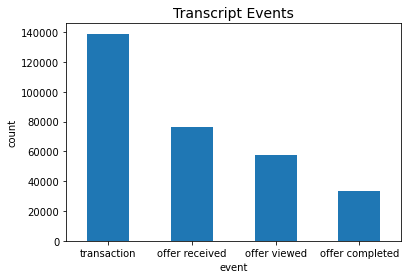

In [111]:
transcript.event.value_counts().plot(kind='bar')
plt.title('Transcript Events', fontsize=14)
plt.ylabel('count')
plt.xlabel('event')
plt.xticks(rotation=0);

the events are encoded as disctionaries. I will put them as individual columns to make them accessible.

In [112]:
def get_dict_value(val_dict, key):
    if key in val_dict:
        return val_dict[key]
    elif key.replace('_', ' ') in val_dict:
        return val_dict[key.replace('_', ' ')]
for key in ['offer_id', 'amount', 'reward']:
    transcript[key] = transcript.value.apply(get_dict_value, key=key)
transcript = transcript.drop(columns='value').copy()



In [113]:
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [114]:
# let's repalce the offer id with a coveniet and understable name from our portfolio dataframe
transcript['offer_id'] = transcript.offer_id.map(offer_dict)
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,b3,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,d1,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,d4,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,d3,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,b2,NaN,NaN


In [115]:
# filling all NaN values in amount and reward with 0
transcript['amount'] = 0 
transcript['reward'] = 0
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,b3,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,d1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,d4,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,d3,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,b2,0,0


I am interested in offer events with viewed and complted status. I will thereofre exclude the transaction status adn offer received status from the dataframe

In [116]:
transcript = transcript[transcript['event'] != 'transaction']
transcript = transcript[transcript['event'] != 'offer received']
transcript['event'].unique()

array(['offer viewed', 'offer completed'], dtype=object)

In [117]:
# save the cleaned dataset
transcript.to_csv('data/transcript.csv', index=False)

##### The main target for our work is to determine how the offers sent are distributed among the differnt customers and their diffent attributes such as demographics

In [118]:
# read in cleaned datasets
portfolio_df = pd.read_csv('data/portfolio.csv')
profile_df = pd.read_csv('data/profile.csv')
transcript_df = pd.read_csv('data/transcript.csv')

rerun the whole notebook
merge dataset and continue wiht the analysis.
finish before 2 pm today please. for our money's sake. we do not have money son.

In [119]:
portfolio_df.head()

,offer_id,offer_type,reward,difficulty,duration,email,mobile,social,web,discount,informational
0,b1,bogo,10,10,7,1,1,1,0,0,0
1,b2,bogo,10,10,5,1,1,1,1,0,0
2,info_1,informational,0,0,4,1,1,0,1,0,1
3,b3,bogo,5,5,7,1,1,0,1,0,0
4,d1,discount,5,20,10,1,0,0,1,1,0


In [120]:
profile_df.head()

,gender,age,person,income,gend_M,gend_O,membership_days
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,376
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,443
2,M,68,e2127556f4f64592b11af22de27a7932,70000.0,1,0,91
3,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,1,0,167
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1,0,257


In [121]:
transcript_df.head()

,person,event,time,offer_id,amount,reward
0,389bc3fa690240e798340f5a15918d5c,offer viewed,0,b4,0,0
1,d1ede868e29245ea91818a903fec04c6,offer viewed,0,info_2,0,0
2,102e9454054946fda62242d2e176fdce,offer viewed,0,b2,0,0
3,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,b1,0,0
4,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,info_2,0,0


In [122]:
# first merge transcript wiht portfolio dataset on offer_id
merged_df = transcript_df.merge(portfolio_df, how='left', on='offer_id')


In [123]:
# merge merged_df with profile on person
merged_df = merged_df.merge(profile, how = 'left', on = 'person')
merged_df.head()

,person,event,time,offer_id,amount,reward_x,offer_type,reward_y,difficulty,duration,...,web,discount,informational,gender,age,income,gend_M,gend_O,membership_days,age_group
0,389bc3fa690240e798340f5a15918d5c,offer viewed,0,b4,0,0,bogo,5,5,5,...,1,0,0,M,65.0,53000.0,1.0,0.0,167.0,senior_citizens
1,d1ede868e29245ea91818a903fec04c6,offer viewed,0,info_2,0,0,informational,0,0,3,...,0,0,1,O,53.0,52000.0,0.0,1.0,313.0,adult
2,102e9454054946fda62242d2e176fdce,offer viewed,0,b2,0,0,bogo,10,10,5,...,1,0,0,F,69.0,57000.0,0.0,0.0,711.0,senior_citizens
3,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,b1,0,0,bogo,10,10,7,...,0,0,0,F,20.0,30000.0,0.0,0.0,745.0,teenager
4,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,info_2,0,0,informational,0,0,3,...,0,0,1,M,39.0,51000.0,1.0,0.0,1521.0,adult


In [124]:
merged_df.describe()

,time,amount,reward_x,reward_y,difficulty,duration,email,mobile,social,web,discount,informational,age,income,gend_M,gend_O,membership_days
count,91304.000000,91304.0,91304.0,91304.000000,91304.000000,91304.000000,91304.0,91304.000000,91304.000000,91304.000000,91304.000000,91304.000000,82304.000000,82304.000000,82304.000000,82304.000000,82304.000000
mean,371.488347,0.0,0.0,4.602285,7.969596,6.700156,1.0,0.933376,0.705522,0.812812,0.431033,0.118626,55.110578,67256.451691,0.543923,0.015479,551.243913
std,198.071423,0.0,0.0,3.340985,4.597125,2.075690,0.0,0.249370,0.455810,0.390064,0.495223,0.323349,17.021547,21357.315304,0.498070,0.123449,411.728999
min,0.000000,0.0,0.0,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,0.000000
25%,198.000000,0.0,0.0,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,44.000000,52000.000000,0.000000,0.000000,231.000000
50%,414.000000,0.0,0.0,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,56.000000,66000.000000,1.000000,0.000000,430.000000
75%,534.000000,0.0,0.0,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,67.000000,82000.000000,1.000000,0.000000,829.000000
max,714.000000,0.0,0.0,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,101.000000,120000.000000,1.000000,1.000000,1823.000000


merged_df.info()

our merged_df dataframe does nto ahve any missing values. I can thereofe carry on with teh analysis part to answer some questions:
1. which gender earns the most income based on the demograhic data provided.
2. what is the most common offer for each fo the age groups, genders?
3. what offers do each gender, age group like?
4. how many of the offers received were completed?
etc.

### 1. Which gender earns the most income based on the demographic data provided?


In [125]:
# first we create income ranges, low, average and high
merged_df['income_range'] = pd.cut(merged_df['income'], bins=[30001, 60001, 90001, 120001], labels=['low', 'average', 'high'])

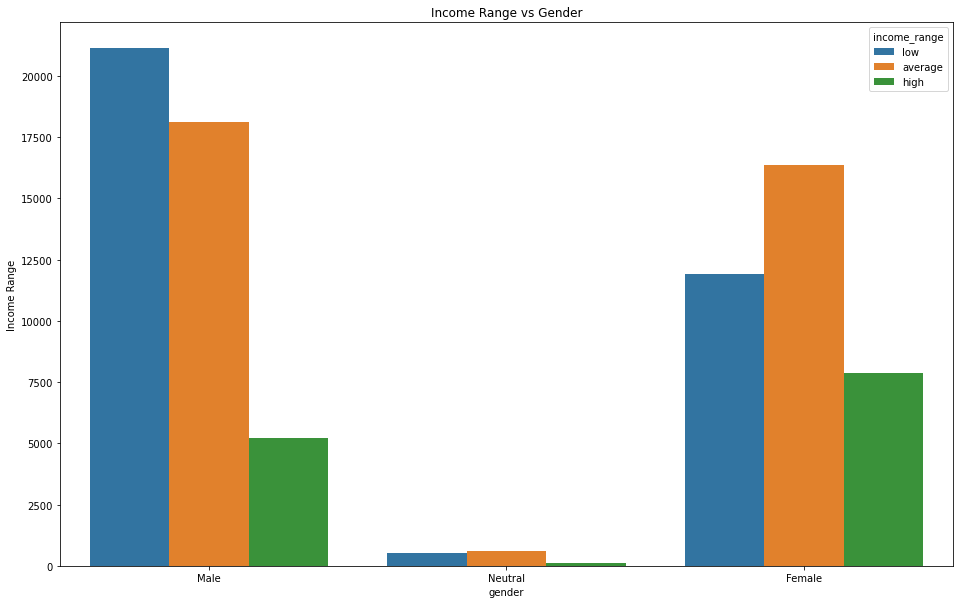

In [126]:
plt.figure(figsize=(16, 10))
g = sns.countplot(x="gender", hue="income_range", data=merged_df)
plt.title('Income Range vs Gender')
plt.ylabel('Income Range')
xlabels = ['Male', 'Neutral', 'Female']
g.set_xticklabels(xlabels)
plt.show();

In [127]:
merged_df.gender.value_counts()


M    44767
F    36263
O     1274
Name: gender, dtype: int64

More females earn average income 30001 to 60000 while more male customers earn Low income. However there are more male customers in the dataset than are other genders. 

### 2. what is the most common offer for each fo the age groups?

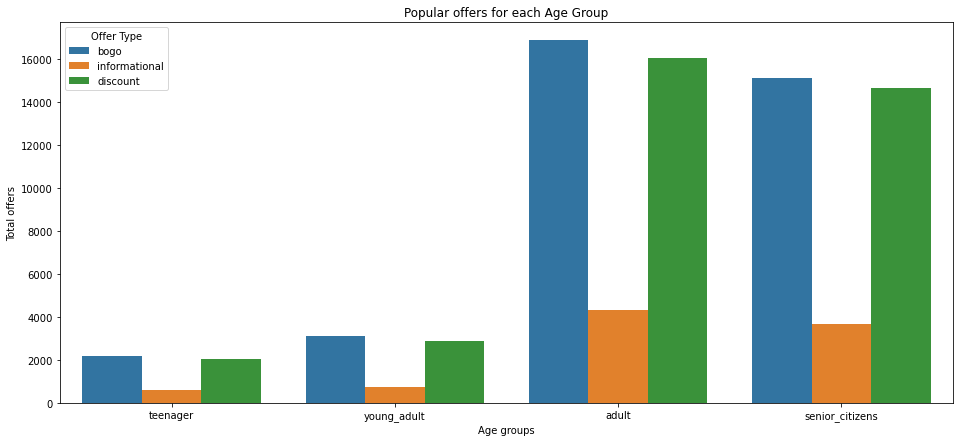

In [128]:
plt.figure(figsize = (16, 7))
g = sns.countplot(x ="age_group", hue='offer_type', data=merged_df)
plt.title("Popular offers for each Age Group")
plt.ylabel('Total offers')
plt.xlabel('Age groups')
xlabels = ['teenager', 'young_adult', 'adult', 'senior_citizens']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title = 'Offer Type')
plt.show();

Across the customer age groups, Bogo and discount offers seem to be the most popular. The two types of offer seem to almost be balanced in each fo the age groups that is covered in teh experiement. These seem ot be the msot attractive compared to the otehr offers that are offered by the company, starbucks.

### 3. what is the most common offer for each gender?

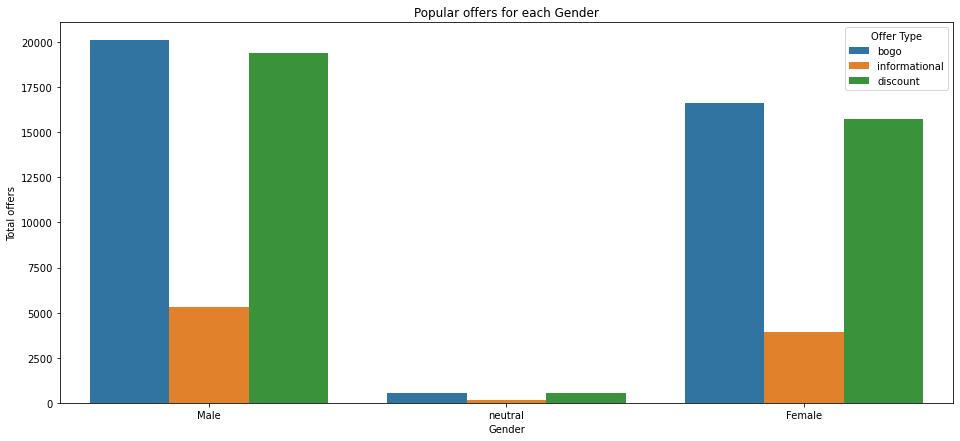

In [129]:
# popular offers for each gender
plt.figure(figsize = (16, 7))
g = sns.countplot(x ="gender", hue='offer_type', data=merged_df)
plt.title("Popular offers for each Gender")
plt.ylabel('Total offers')
plt.xlabel('Gender')
xlabels = ['Male', 'neutral', 'Female']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title = 'Offer Type')
plt.show();

It seems that the offer distribution for the genders has bogo offers adn dicount offers toppign the list with informational offers lagging behind

### 3. what offers do each gender like?

from the above chart we can assume that most of the customers like the offers that they recieve most. 


### 4. how many of the offers received were completed?

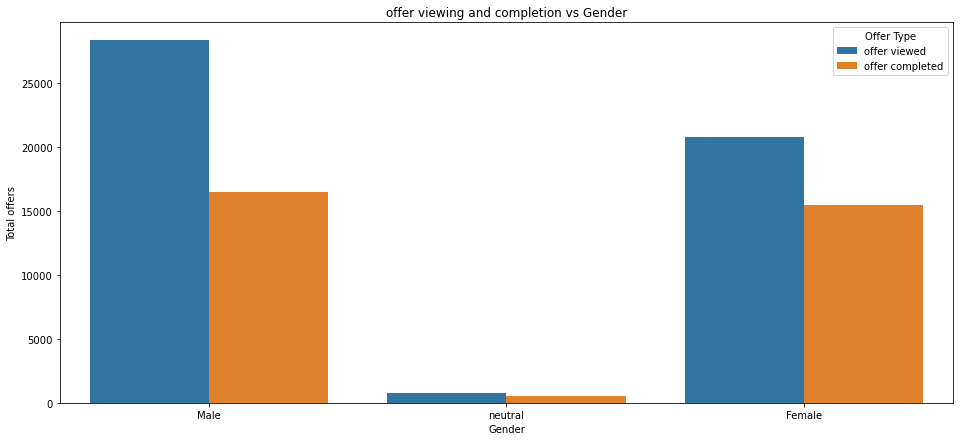

In [130]:
plt.figure(figsize = (16, 7))
g = sns.countplot(x ="gender", hue='event', data=merged_df)
plt.title("offer viewing and completion vs Gender")
plt.ylabel('Total offers')
plt.xlabel('Gender')
xlabels = ['Male', 'neutral', 'Female']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title = 'Offer Type')
plt.show();

More offers were viewed than were completed. Viewing the offer did nto compel the customer to complete the offer. More male than female customers just viewed the offers but never completed them. The gender neutral group however seems to have an almost equal viewing and completion status on the offers received

In [131]:
merged_df.head()

,person,event,time,offer_id,amount,reward_x,offer_type,reward_y,difficulty,duration,...,discount,informational,gender,age,income,gend_M,gend_O,membership_days,age_group,income_range
0,389bc3fa690240e798340f5a15918d5c,offer viewed,0,b4,0,0,bogo,5,5,5,...,0,0,M,65.0,53000.0,1.0,0.0,167.0,senior_citizens,low
1,d1ede868e29245ea91818a903fec04c6,offer viewed,0,info_2,0,0,informational,0,0,3,...,0,1,O,53.0,52000.0,0.0,1.0,313.0,adult,low
2,102e9454054946fda62242d2e176fdce,offer viewed,0,b2,0,0,bogo,10,10,5,...,0,0,F,69.0,57000.0,0.0,0.0,711.0,senior_citizens,low
3,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,b1,0,0,bogo,10,10,7,...,0,0,F,20.0,30000.0,0.0,0.0,745.0,teenager,NaN
4,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,info_2,0,0,informational,0,0,3,...,0,1,M,39.0,51000.0,1.0,0.0,1521.0,adult,low


## Modeling

for this part, we will model and evaluate differnt Models perfomances, in this case i will use accuracy a hte metric. Accuracy is most applicable for this case since it is a classification probelm and it shows how eell our model predicted 

In [132]:
merged_df.columns

Index(['person', 'event', 'time', 'offer_id', 'amount', 'reward_x',
       'offer_type', 'reward_y', 'difficulty', 'duration', 'email', 'mobile',
       'social', 'web', 'discount', 'informational', 'gender', 'age', 'income',
       'gend_M', 'gend_O', 'membership_days', 'age_group', 'income_range'],
      dtype='object')

The important features for our modeling work are:
- time
- offer_id
- amount
- reward_x
- offer_type
- reward_y
- dificulty
- duration
- gender
- age_group
- income_range
- membership_days

we will target the event wchih can be either of the two <b> offer completed </b><b>or offer viewed</b>


First I will encode the columns with object dtype with numericical values

In [133]:
merged_df.dtypes

person               object
event                object
time                  int64
offer_id             object
amount                int64
reward_x              int64
offer_type           object
reward_y              int64
difficulty            int64
duration              int64
email                 int64
mobile                int64
social                int64
web                   int64
discount              int64
informational         int64
gender               object
age                 float64
income              float64
gend_M              float64
gend_O              float64
membership_days     float64
age_group          category
income_range       category
dtype: object

In [134]:
merged_df['event'].value_counts()

offer viewed       57725
offer completed    33579
Name: event, dtype: int64

In [135]:
from sklearn.preprocessing import LabelEncoder

#label econder instance
lbl_encoder = LabelEncoder()

# df containing interest features
# interest_df = merged_df[['event', 'offer_type', 'gender', 'age_group', 'income_rannge

merged_df['event_cat'] = lbl_encoder.fit_transform(merged_df['event'])
merged_df.head()

,person,event,time,offer_id,amount,reward_x,offer_type,reward_y,difficulty,duration,...,informational,gender,age,income,gend_M,gend_O,membership_days,age_group,income_range,event_cat
0,389bc3fa690240e798340f5a15918d5c,offer viewed,0,b4,0,0,bogo,5,5,5,...,0,M,65.0,53000.0,1.0,0.0,167.0,senior_citizens,low,1
1,d1ede868e29245ea91818a903fec04c6,offer viewed,0,info_2,0,0,informational,0,0,3,...,1,O,53.0,52000.0,0.0,1.0,313.0,adult,low,1
2,102e9454054946fda62242d2e176fdce,offer viewed,0,b2,0,0,bogo,10,10,5,...,0,F,69.0,57000.0,0.0,0.0,711.0,senior_citizens,low,1
3,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,b1,0,0,bogo,10,10,7,...,0,F,20.0,30000.0,0.0,0.0,745.0,teenager,NaN,1
4,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,info_2,0,0,informational,0,0,3,...,1,M,39.0,51000.0,1.0,0.0,1521.0,adult,low,1


In [136]:
#drop rows with NaN values
merged_df.dropna(axis=0, inplace=True)

In [137]:
merged_df['offer_type_cat'] = lbl_encoder.fit_transform(merged_df['offer_type'])
merged_df['gender_cat'] = lbl_encoder.fit_transform(merged_df['gender'])
merged_df['age_group_cat'] = lbl_encoder.fit_transform(merged_df['age_group'])
merged_df['income_range_cat'] = lbl_encoder.fit_transform(merged_df['income_range'])
merged_df['offer_id_cat'] = lbl_encoder.fit_transform(merged_df['offer_id'])
merged_df['event_cat'] = lbl_encoder.fit_transform(merged_df['event'])

In [138]:
# Spliting data into features and target label
X = merged_df[['time', 'offer_id_cat', 'amount', 'reward_x', 
               'offer_type_cat', 'difficulty', 'email', 'mobile', 'social', 'web',
               'duration', 'gender_cat', 'age_group_cat', 'income_range_cat', 'membership_days']]
y = merged_df['event_cat']

In [139]:
X.head()

,time,offer_id_cat,amount,reward_x,offer_type_cat,difficulty,email,mobile,social,web,duration,gender_cat,age_group_cat,income_range_cat,membership_days
0,0,3,0,0,0,5,1,1,1,1,5,1,1,2,167.0
1,0,9,0,0,2,0,1,1,1,0,3,2,0,2,313.0
2,0,1,0,0,0,10,1,1,1,1,5,0,1,2,711.0
4,0,9,0,0,2,0,1,1,1,0,3,1,0,2,1521.0
5,0,7,0,0,1,10,1,1,0,1,7,1,0,1,921.0


In [140]:
y.head()

0    1
1    1
2    1
4    1
5    1
Name: event_cat, dtype: int32

In [141]:
# scaling some variables before model building and training
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features = ['time', 'amount', 'reward_x', 'difficulty', 'duration', 'membership_days']
X_scaled = X.copy()
X_scaled[features] = scaler.fit_transform(X_scaled[features])
X = X_scaled
X.head()

,time,offer_id_cat,amount,reward_x,offer_type_cat,difficulty,email,mobile,social,web,duration,gender_cat,age_group_cat,income_range_cat,membership_days
0,0.0,3,0.0,0.0,0,0.25,1,1,1,1,0.285714,1,1,2,0.091607
1,0.0,9,0.0,0.0,2,0.00,1,1,1,0,0.000000,2,0,2,0.171695
2,0.0,1,0.0,0.0,0,0.50,1,1,1,1,0.285714,0,1,2,0.390016
4,0.0,9,0.0,0.0,2,0.00,1,1,1,0,0.000000,1,0,2,0.834339
5,0.0,7,0.0,0.0,1,0.50,1,1,0,1,0.571429,1,0,1,0.505211


In [142]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split
# training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

I will try four models  and select the best from them
- Support Vector Machine
- naive bayes
- Decision Trees
- K-Nearest Neighbors

### 1. Support Vector machine




In [143]:
from sklearn.svm import SVC

svm = SVC(gamma = 'auto')

svm.fit(X_train, y_train)
print(f'Accuracy of SVM on testing data: {round(svm.score(X_train, y_train)* 100, 4)}%.')

svm_preds = svm.predict(X_test)
print(f'prediction Accuracy: {accuracy_score(y_test, svm_preds)* 100}%')

Accuracy of SVM on testing data: 63.692%.
prediction Accuracy: 63.50275865436258%


### 2. Naive Bayes

In [144]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f'Accuracy of gnb on testing data: {round(gnb.score(X_train, y_train)* 100, 4)}%.')

gnb_preds = gnb.predict(X_test)
print(f'prediction Accuracy: {accuracy_score(y_test, gnb_preds)* 100}%')

Accuracy of gnb on testing data: 63.7441%.
prediction Accuracy: 63.36116400566378%


### 3. Decision Trees

In [145]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
print(f'Accuracy of Decision Tree on testing data: {round(DT.score(X_train, y_train)* 100, 4)}%.')

DT_preds = DT.predict(X_test)
print('prediction Accuracy:', accuracy_score(y_test, DT_preds)* 100)

Accuracy of Decision Tree on testing data: 97.4626%.
prediction Accuracy: 59.069381377862406


### 4. K-nearest neighbours

In [146]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(f'Accuracy of KNN on testing data: {round(knn.score(X_train, y_train)* 100, 4)}%.')

knn_preds = knn.predict(X_test)
print(f'prediction Accuracy: {accuracy_score(y_test, knn_preds)* 100}%')

Accuracy of KNN on testing data: 74.3445%.
prediction Accuracy: 59.79688491772862%


### 5. Improvement of SVC model using GridSearchCV

### Model Evaluation and Validation

The above models each has a differnt accuracy score. the best perfoming model is Naive bayes model with an accuracy prediction score of 63.36%. This is the mdoel that closely maches the trainign accuracy with the prediction accuracy in my work. I belive that there are ways to fine tune the mdoel and improve on the accuracy. however at the moment it is the most applicable in solving a binary outcome problem on whther a customer will just view the offer or whetehr they will complete the offer altogetehr. to view an offer it must be recived therefore I did not consider this event. 

### model refinement
The perfomace fo the models can be improved by fine tuning the features and or usign GridSearchCV. Below I use the GridSearchCV approach

In [ ]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.001],
    'kernel': ['rbf']
}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose = 3)

grid.fit(X_train, y_train)
print(f'Accuracy of grid on testing data: {round(grid.score(X_train, y_train)* 100, 4)}%.')

grid_preds = grid.predict(X_test)
print(f'prediction Accuracy: {accuracy_score(y_test, grid_preds)* 100}%')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....................C=0.1, gamma=1, kernel=rbf; total time= 4.7min
[CV 2/5] END .....................C=0.1, gamma=1, kernel=rbf; total time= 4.7min
[CV 3/5] END .....................C=0.1, gamma=1, kernel=rbf; total time= 4.5min
[CV 4/5] END .....................C=0.1, gamma=1, kernel=rbf; total time= 4.6min
[CV 5/5] END .....................C=0.1, gamma=1, kernel=rbf; total time= 4.6min
[CV 1/5] END ...................C=0.1, gamma=0.1, kernel=rbf; total time= 4.4min
[CV 2/5] END ...................C=0.1, gamma=0.1, kernel=rbf; total time= 4.5min
[CV 3/5] END ...................C=0.1, gamma=0.1, kernel=rbf; total time= 4.5min
[CV 4/5] END ...................C=0.1, gamma=0.1, kernel=rbf; total time= 4.5min
[CV 5/5] END ...................C=0.1, gamma=0.1, kernel=rbf; total time= 5.0min
[CV 1/5] END .................C=0.1, gamma=0.001, kernel=rbf; total time= 5.6min
[CV 2/5] END .................C=0.1, gamma=0.001,

In [ ]:
print(f'Accuracy of grid on testing data: {round(grid.score(X_train, y_train)* 100, 4)}%.')
print(f'prediction Accuracy: {accuracy_score(y_test, grid_preds)* 100}%')

In [ ]:
# creating the variables that will be used to fill the results table
models = [svm, DT, gnb, knn, grid]
model_names = [type(n).__name__ for n in models]
training_accuracy = [x.score(X_train, y_train)*100 for x in models]
predection_accuracy = [accuracy_score(y) for y in models]

# structuring a table to view the results of the different model tried above
results = [training_accuracy, predection_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy'])

# show the results dataframe 
results_df

### Conclusion

In this project i have tried to analyse and predict how a customer wodul respond to an offer by starbucks. The two opptions i have considered, considerign that the customer has already received the offer are whtehr they wodul just view it or they woduld go ahead and complete it. 
The model perfomance was not that good but it showed that it can predict whetehr a customer will view the offer or whether they will complete the offer altogether. 

I am hoping to continue workign on the model later once I have reviewed more resources on model training and feature selection. 

I enjoyed working with the data in this case and developing a sole project based on skills i have learned on Udacity. 